<a href="https://colab.research.google.com/github/raja0640/cp640/blob/main/Jude_Rajasooriar_205800640_CP640_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Application of LSTM-RNN for forecasting Bitcoin prices.**

*   **Author** : Jude Rajasooriar
*   **Course** : CP640-OC1: Machine Learning.
*   **Department** : Department of Physics and Computer Science, Wilfrid Laurier University.
*   **Instructor** : Professor Elham Harirpoush
*   **Date**   : July 31, 2022.

As discussed in the project proposal, we will be developing a Machine Learning model to predict the Bitcoin prices for the next day (or next `n` days) using the Bitcoin market data with minute-to-minute updates collected from select cryptocurrency exchanges from January 2012 to December 2021. The historical time series data is from [kaggle.com - Bitcoin Historical Data](https://www.kaggle.com/datasets/mczielinski/bitcoin-historical-data).

The data have been collected by calling the exchange's respective APIs for the Bitcoin exchange rate in USD. The timestamps are in Unix time. The other columns in the dataset include OHLC (Open, High, Low, Close) data, Volume in BTC and indicated currency, and weighted bitcoin price (Zielak, 2021). 

We will be transforming the Bitcoin historical timeseries data into a supervision problem by building a Recurrent Neural Network (RNN) regressor, trainned from samples from the above dataset. We will use [Keras](https://keras.io/) a popular high-level neural networks library to build our models.

RNNs are used for sequence and temporal problems because it maintains the states from prior inputs to influence the current input and output. The primary forcus of this study will be in developping a model based on Long short-term memory (LSTM) architecture that solves vanishing gradient problem and can be used to predict Bitcoin prices from data seen in previous timesteps. 



## Install packages and Import libraries.

In this section we will be installing the Tensorflow and keras packages and import all the python libraries like numpy, pandas, sklearn, etc. required for our project. 

### Install Tensorflow and keras.


In [1]:
!pip install Tensorflow
!pip install keras

!pip install tensorflow --upgrade
!pip install keras --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 511.7 MB 7.0 kB/s 
     |████████████████████████████████| 438 kB 50.4 MB/s 
     |████████████████████████████████| 1.6 MB 54.6 MB/s 
     |████████████████████████████████| 5.8 MB 61.9 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstallin

### Import libraries

In [3]:
# Download the dataset from google drive.
import gdown

# Data Exploration and pre-processing packages
import numpy as np 
import pandas as pd 
from datetime import datetime
import time
import math
import missingno as msno
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler

# Data Visualization Packages
import matplotlib.pyplot as plt

# Importing the Keras libraries and packages
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import SimpleRNN
from keras.layers import Dense
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint


## Download the dataset

The Bitcoin-Historical-Data dataset was downloaded from [kaggle.com - Bitcoin Historical Data](https://www.kaggle.com/datasets/mczielinski/bitcoin-historical-data) and saved in to a shared google drive folder. We will be downloading the dataset (csv format) to this session from google drive using the gdown library. 

In [4]:

# Download the dataset from https://drive.google.com/file/d/1F4lpnRvxhvdxF6VJYvfr3LrmwxQpXTEn/view?usp=sharing
!gdown 1F4lpnRvxhvdxF6VJYvfr3LrmwxQpXTEn

Downloading...
From: https://drive.google.com/uc?id=1F4lpnRvxhvdxF6VJYvfr3LrmwxQpXTEn
To: /content/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv
100% 318M/318M [00:03<00:00, 86.3MB/s]


# Data Exploration

Here we read the ` bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv` file downloaded in the previous step to a pandas dataframe for analysis. We check the dataset for rows with missing values, and by reviewing the statistics, we can determine the best parameters to use to train our model.

```
input_btc_df.describe(include="all")
```

The output from the above statement Reveals that either the Closing price ` Close` or the `Weighted_Price` paramters can be used for predicting the Bitcoin price for the next day or next `n` days. `Weighted_Price` is the mean of OHLC values; hence I feel it is the best parameter for the model. 

Another observation here is we have to group all the rows by date so that the model can be trained for daily price predictions. We have to add a new date column to the dataset based on the timestamp which we will do in the data preprocessing step.



### Explore dataset

Shape of the raw dataset : (4857377, 8)

Display the first few rows of the dataset.


,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Display the dataset information.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4857377 entries, 0 to 4857376
Data columns (total 8 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Timestamp          int64  
 1   Open               float64
 2   High               float64
 3   Low                float64
 4   Close              float64
 5   Volume_(BTC)       float64
 6   Volume_(Currency)  float64
 7   Weighted_Price     float64
dtypes: float64(7), int64(1)
memory usage: 296.5 MB


None


Rename Volume_(BTC) column header to Volume_BTC  and Volume_(Currency) column header to Volume_USD.

Display the last few rows of the dataset after renaming the columns.


,Timestamp,Open,High,Low,Close,Volume_BTC,Volume_USD,Weighted_Price
4857372,1617148560,58714.31,58714.31,58686.00,58686.00,1.384487,81259.372187,58692.753339
4857373,1617148620,58683.97,58693.43,58683.97,58685.81,7.294848,428158.146640,58693.226508
4857374,1617148680,58693.43,58723.84,58693.43,58723.84,1.705682,100117.070370,58696.198496
4857375,1617148740,58742.18,58770.38,58742.18,58760.59,0.720415,42332.958633,58761.866202
4857376,1617148800,58767.75,58778.18,58755.97,58778.18,2.712831,159417.751000,58764.349363



Display the dataset statistics.


,Timestamp,Open,High,Low,Close,Volume_BTC,Volume_USD,Weighted_Price
count,4.857377e+06,3.613769e+06,3.613769e+06,3.613769e+06,3.613769e+06,3.613769e+06,3.613769e+06,3.613769e+06
mean,1.471301e+09,6.009024e+03,6.013357e+03,6.004488e+03,6.009014e+03,9.323249e+00,4.176284e+04,6.008935e+03
std,8.428019e+07,8.996247e+03,9.003521e+03,8.988778e+03,8.996360e+03,3.054989e+01,1.518248e+05,8.995992e+03
min,1.325318e+09,3.800000e+00,3.800000e+00,1.500000e+00,1.500000e+00,0.000000e+00,0.000000e+00,3.800000e+00
25%,1.398179e+09,4.438600e+02,4.440000e+02,4.435200e+02,4.438600e+02,4.097759e-01,4.521422e+02,4.438306e+02
50%,1.471428e+09,3.596970e+03,3.598190e+03,3.595620e+03,3.597000e+03,1.979811e+00,3.810124e+03,3.596804e+03
75%,1.544288e+09,8.627270e+03,8.632980e+03,8.621090e+03,8.627160e+03,7.278216e+00,2.569821e+04,8.627637e+03
max,1.617149e+09,6.176356e+04,6.178183e+04,6.167355e+04,6.178180e+04,5.853852e+03,1.390067e+07,6.171621e+04



Check the Weighted Price values in the dataset.


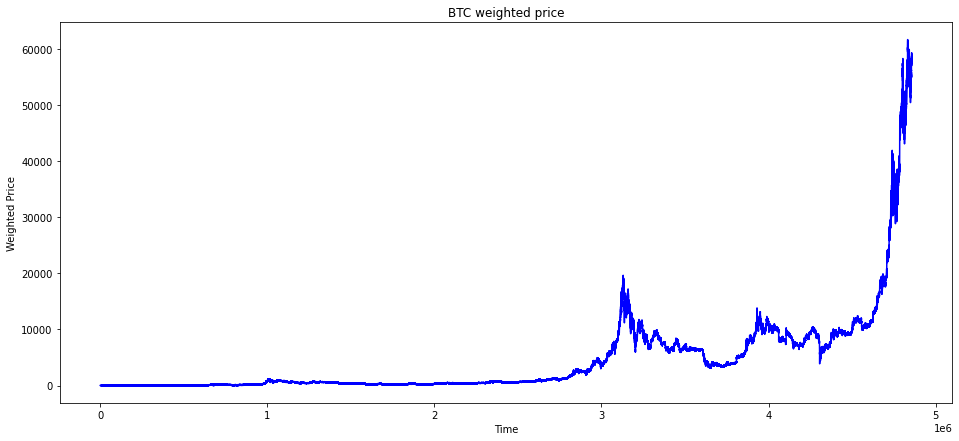

In [6]:
# Import data
input_btc_df = pd.read_csv('bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv')
print("Shape of the raw dataset :", input_btc_df.shape)
print("\nDisplay the first few rows of the dataset.")
display(input_btc_df.head())

# Dataset information
print("\nDisplay the dataset information.")
display(input_btc_df.info())

# Rename columns 
print("\nRename Volume_(BTC) column header to Volume_BTC  and Volume_(Currency) column header to Volume_USD.")
input_btc_df.rename(columns={"Volume_(BTC)": f"Volume_BTC", "Volume_(Currency)": f"Volume_USD"}, inplace=True)
print("\nDisplay the last few rows of the dataset after renaming the columns.")
display(input_btc_df.tail())

# Dataset Statistics
print("\nDisplay the dataset statistics.")
display(input_btc_df.describe(include="all"))

print("\nCheck the Weighted Price values in the dataset.")
plt.figure(figsize=(16,7))
plt.plot(input_btc_df['Weighted_Price'], 'b')
plt.xlabel("Time")
plt.ylabel("Weighted Price")
plt.title("BTC weighted price")
plt.show()

### Check for missing data

Check if the dataset contains missing data. We use the pandas function 
```
input_btc_df.isnull().sum()
```

to get an idea of the number of rows with missing values. We also use the missingno library matrix plot method to visualize the missing data.

We can observe that ~26% of the rows contain empty values.


Display missing data by feature (column).


Timestamp               0
Open              1243608
High              1243608
Low               1243608
Close             1243608
Volume_BTC        1243608
Volume_USD        1243608
Weighted_Price    1243608
dtype: int64

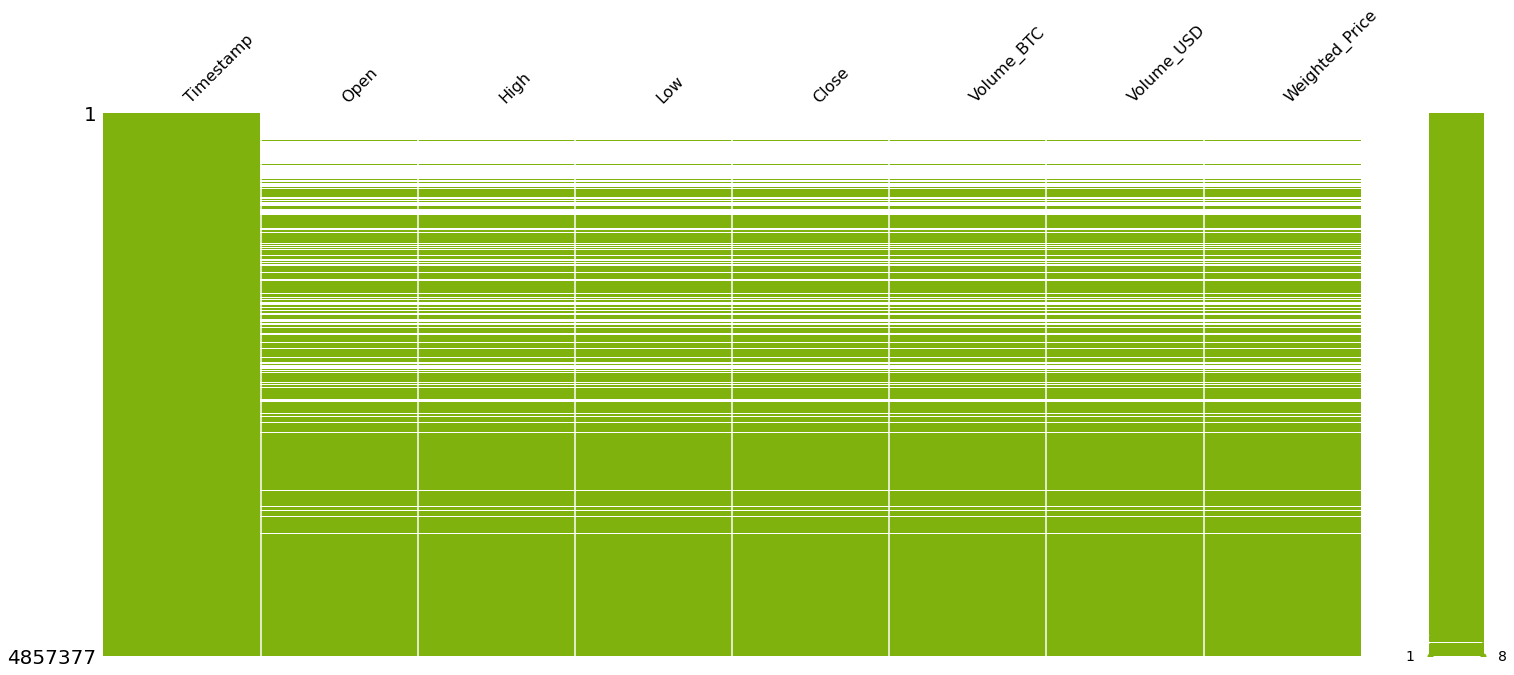

In [7]:
# Check for missing values in the dataset
print("Display missing data by feature (column).")
display(input_btc_df.isnull().sum()) 

msno.matrix(input_btc_df, color=(.5,.7,.05));

# Data Preprocessing

In data preprocessing, we will first drop the rows with missing data, add a new date column to the data set and group the `weighted_price` values by date so that we can train the model by date.

We also split the dataset into training and test sets, feature scale the respective datasets and transform the training and test data to datastructures suitable for model training and validation.


## Missing value handling

We drop the rows containg missing values identifed in the previous section by calling the following function. 

```
input_btc_df.dropna().reset_index(drop=True)
```

Since we are dealing with timeseries data, and are unable fill the missing values this step is essential to maintain the sequence of the dataset and improve the model's performance. 

The result of the `input_btc_df.isnull().sum()` function and the `missingno` matrix plot shows that all the rows with missing data are dropped.

Shape of the dataset after dropping the rows containing NaN values : (3613769, 8)
(3613769, 8)
25.602459928475803% of the rows dropped from the dataset.

Check for missing data after dropping the rows containing NaN values.


Timestamp         0
Open              0
High              0
Low               0
Close             0
Volume_BTC        0
Volume_USD        0
Weighted_Price    0
dtype: int64


Check the Weighted Price values in the dataset.


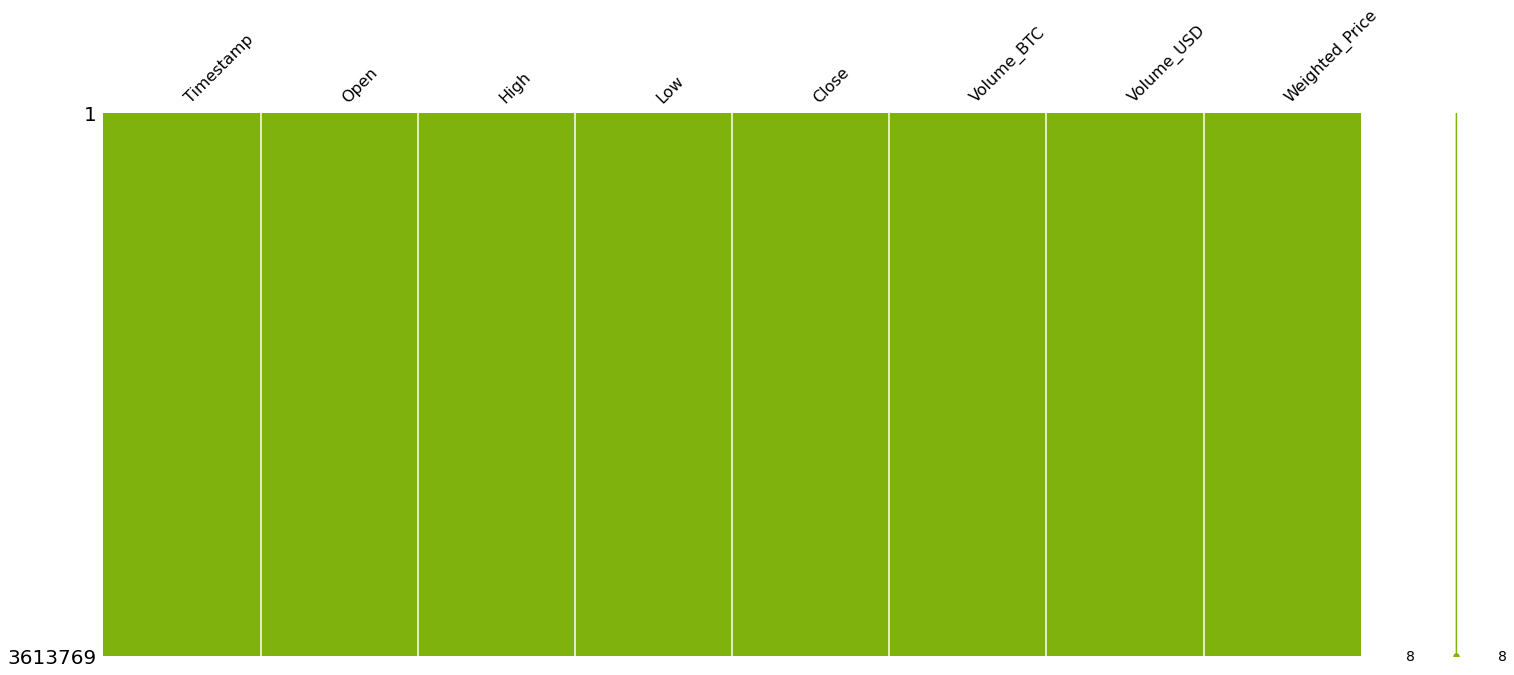

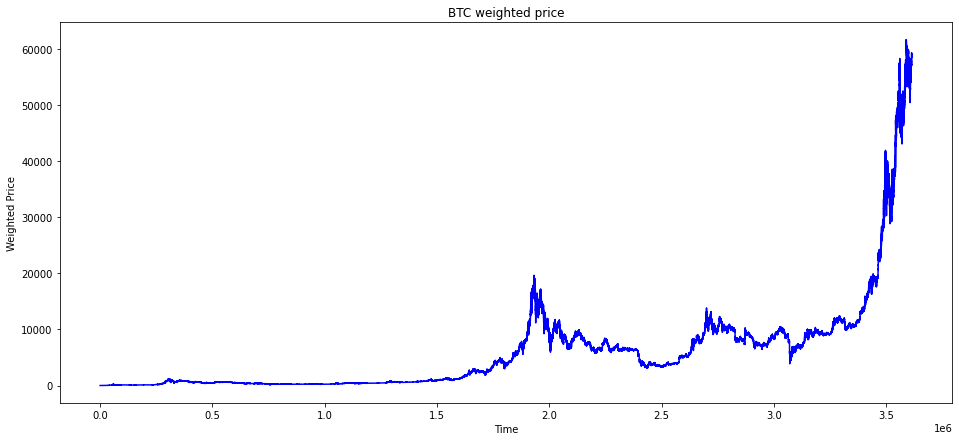

In [7]:
total_num_of_rows = input_btc_df.shape[0]
# Delete the rows with missing value and check the dataset again 
input_btc_df = input_btc_df.dropna().reset_index(drop=True)
print("Shape of the dataset after dropping the rows containing NaN values :", input_btc_df.shape)
print(input_btc_df.shape)
num_of_clean_rows = input_btc_df.shape[0]

print(f"{(total_num_of_rows-num_of_clean_rows)/total_num_of_rows * 100}% of the rows dropped from the dataset.")

print("\nCheck for missing data after dropping the rows containing NaN values.")
display(input_btc_df.isnull().sum()) 
msno.matrix(input_btc_df, color=(.5,.7,.05));

print("\nCheck the Weighted Price values in the dataset.")
plt.figure(figsize=(16,7))
plt.plot(input_btc_df['Weighted_Price'], 'b')
plt.xlabel("Time")
plt.ylabel("Weighted Price")
plt.title("BTC weighted price")
plt.show()

## Prepare data.

The dataset contains unix timestamp of the starting time of the 60 second window (each row in the dataset). We have to add a new column called `date` to group the `weighted_price` by date. 

I trained the model using both ` weighted_price` and `closing price` in each window, so the code below creates two separate group by dataframes. I used the `btc_weighted_price_groupby_date` for the final implementation but decided to leave  `btc_closing_price_groupby_date`  intact for future reference.


Display the dataset information.


,Timestamp,Open,High,Low,Close,Volume_BTC,Volume_USD,Weighted_Price,date
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000,2011-12-31
1,1325346600,4.39,4.39,4.39,4.39,48.000000,210.720000,4.390000,2011-12-31
2,1325350740,4.50,4.57,4.50,4.57,37.862297,171.380338,4.526411,2011-12-31
3,1325350800,4.58,4.58,4.58,4.58,9.000000,41.220000,4.580000,2011-12-31
4,1325391360,4.58,4.58,4.58,4.58,1.502000,6.879160,4.580000,2012-01-01


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3613769 entries, 0 to 3613768
Data columns (total 9 columns):
 #   Column          Dtype  
---  ------          -----  
 0   Timestamp       int64  
 1   Open            float64
 2   High            float64
 3   Low             float64
 4   Close           float64
 5   Volume_BTC      float64
 6   Volume_USD      float64
 7   Weighted_Price  float64
 8   date            object 
dtypes: float64(7), int64(1), object(1)
memory usage: 248.1+ MB


None


Group the data by Date.

Display the grouped weighted_Price.
Shape of the btc_weighted_price_groupby_date : (3376,)


date
2011-12-31    4.471603
2012-01-01    4.806667
2012-01-02    5.000000
2012-01-03    5.252500
2012-01-04    5.208159
Name: Weighted_Price, dtype: float64


Display the grouped Close.
Shape of the btc_closing_price_groupby_date : (3376,)


date
2021-03-27    55195.415367
2021-03-28    55835.012863
2021-03-29    56915.629993
2021-03-30    58349.357087
2021-03-31    58778.180000
Name: Close, dtype: float64

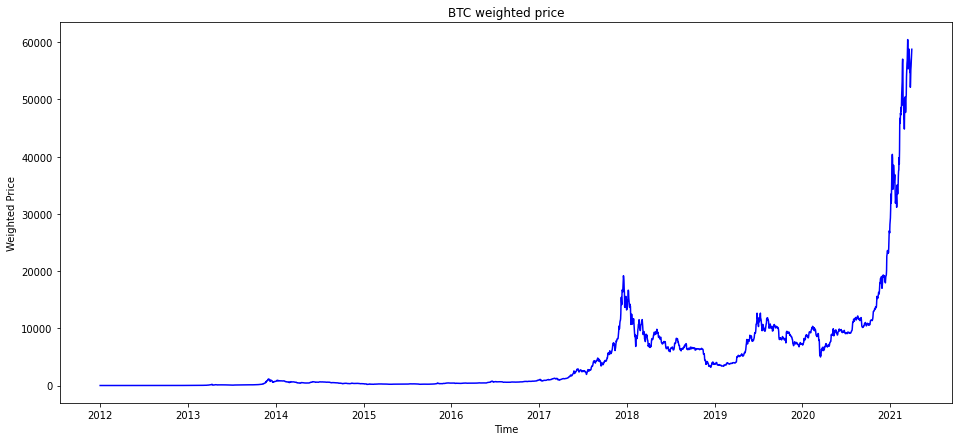

In [19]:
# Add a date column to the data frame and convert the timestamp to date format and save the values in the new column.
input_btc_df["date"]=pd.to_datetime(input_btc_df["Timestamp"],unit="s").dt.date
print("Display the dataset information.")
display(input_btc_df.head())
display(input_btc_df.info())

print("\nGroup the data by Date.")
group_by_date = input_btc_df.groupby('date')

btc_weighted_price_groupby_date = group_by_date['Weighted_Price'].mean()
btc_closing_price_groupby_date = group_by_date['Close'].mean()

print("\nDisplay the grouped weighted_Price.")
print("Shape of the btc_weighted_price_groupby_date :", btc_weighted_price_groupby_date.shape)
display(btc_weighted_price_groupby_date.head())
print("\nDisplay the grouped Close.")
print("Shape of the btc_closing_price_groupby_date :", btc_closing_price_groupby_date.shape)
display(btc_closing_price_groupby_date.tail())

plt.figure(figsize=(16,7))
plt.plot(btc_weighted_price_groupby_date, 'b')
#plt.plot(btc_closing_price_groupby_date, 'b')
plt.xlabel("Time")
plt.ylabel("Weighted Price")
plt.title("BTC weighted price")
plt.show()


## Train and Test data split.

It is important to partition the input dataset to seperate tranning and test datasets respectively  before applying any data normalization (Myrianthous, 2020).

This is erroneous because the normalization technique will use data from the test sets as a reference point if scaling is applied against the input dataset (before partitioning). This will inadvertently influence the training data's values, resulting in data leakage from the test sets (Myrianthous, 2020).

There are several partitioning stratergies we can explore like Random sampling, strattified sampling and Linear sampling. But since we are working with a dataset containing time-series data and our goal is to forecast Bitcoin prices from it, the ideal partitioning strategy is the  `take from the top` sampling strategy that preserves the time-series sequence. 

The take from the top sampling strategy selects the first `n` number of rows for training and uses the remaing rows for model evaluation. 

I’ve evaluated two options as seen below. 1) keep the last 60 days (rows) of data for testing and use the top 3316 samples for training. 2)  keep the last `n%` of data for testing and use the rest of the top samples for training. 
Overfitting was observed constantly with option 1 with a high RMSE rate. However, the model generalized well with option 2 with a 10% test set split. 




### Take the last `n%` of the data as the test dataset.

 The model generalized well with this option with a 10% test set split.

 **Note: Please use this option for partitioning.**

Train set size :  3039
Test set size :  337

Display the train dataset

Shape of the train dataset : (3039, 1)


array([[4.47160287e+00],
       [4.80666667e+00],
       [5.00000000e+00],
       ...,
       [7.60379361e+03],
       [7.71597091e+03],
       [7.73087802e+03]])


Display the test dataset

Shape of the test dataset : (337, 1)


array([[ 8245.72238021],
       [ 8894.27598485],
       [ 8784.64278472],
       [ 8873.98953933],
       [ 8979.8925886 ],
       [ 8772.6056095 ],
       [ 8930.91368136],
       [ 9164.28214628],
       [ 9492.19570215],
       [ 9924.46195119],
       [ 9727.20938074],
       [ 8687.48543576],
       [ 8706.76233411],
       [ 8774.26843278],
       [ 9045.86295186],
       [ 9577.18013002],
       [ 9523.73706092],
       [ 9403.56427666],
       [ 9626.8802625 ],
       [ 9721.81916606],
       [ 9670.35267339],
       [ 9670.78564814],
       [ 9279.32202627],
       [ 9124.64939675],
       [ 9205.78390063],
       [ 9119.08426397],
       [ 8819.20482399],
       [ 8859.41674511],
       [ 9030.15356131],
       [ 9321.50428794],
       [ 9454.19439488],
       [ 9507.29208285],
       [ 9546.66735901],
       [ 9585.24282325],
       [ 9880.58289624],
       [ 9551.91896246],
       [ 9700.43932304],
       [ 9742.02892493],
       [ 9637.02495875],
       [ 9618.21326033],


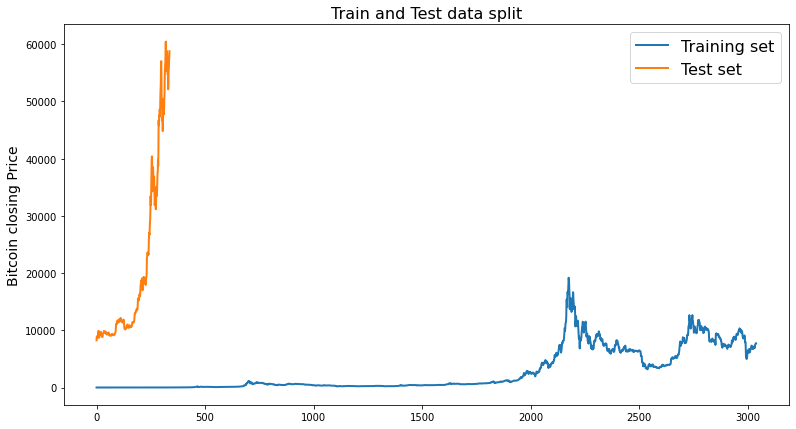

In [35]:
test_set_percentage = 0.10
#test_set_size = int(len(btc_closing_price_groupby_date) * test_set_percentage)
#train_set_size = len(btc_closing_price_groupby_date) - test_set_size

test_set_size = int(len(btc_weighted_price_groupby_date) * test_set_percentage)
train_set_size = len(btc_weighted_price_groupby_date) - test_set_size

print("Train set size : ", train_set_size)
print("Test set size : ", test_set_size)

#train_set= btc_closing_price_groupby_date.iloc[0:train_set_size].values.reshape(-1,1)
train_set= btc_weighted_price_groupby_date.iloc[0:train_set_size].values.reshape(-1,1)

#test_set= btc_closing_price_groupby_date.iloc[train_set_size:len(btc_closing_price_groupby_date)].values.reshape(-1,1)
test_set= btc_weighted_price_groupby_date.iloc[train_set_size:len(btc_weighted_price_groupby_date)].values.reshape(-1,1)

print("\nDisplay the train dataset")
print("\nShape of the train dataset :", train_set.shape)
display(train_set)

print("\nDisplay the test dataset")
print("\nShape of the test dataset :", test_set.shape)
display(test_set)

_, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(train_set, label='Training set', linewidth=2)
ax.plot(test_set, label='Test set', linewidth=2)
ax.set_ylabel('Time', fontsize=14)
ax.set_ylabel('Bitcoin closing Price', fontsize=14)
ax.set_title('Train and Test data split', fontsize=16)
ax.legend(loc='best', fontsize=16)

### Take the last `60` days as the test dataset.

The experiments resulted in Overfitting. 

**Note: Please do not use this option**


Display the train dataset

Shape of the train dataset : (3316, 1)


array([[4.47160287e+00],
       [4.80666667e+00],
       [5.00000000e+00],
       ...,
       [3.17938844e+04],
       [3.50514678e+04],
       [3.40537126e+04]])


Display the test dataset

Shape of the test dataset : (60, 1)


array([[33450.93785876],
       [33705.97519065],
       [34713.69640011],
       [36573.09481031],
       [37541.54813242],
       [37630.049214  ],
       [39814.35655457],
       [38711.77455525],
       [41196.61444487],
       [46684.49084956],
       [45798.73371536],
       [46272.21566854],
       [47603.41542012],
       [47273.84991914],
       [48600.49151849],
       [47862.39794598],
       [48845.16600343],
       [50913.92413875],
       [51893.31118122],
       [53083.8791088 ],
       [56271.28853768],
       [57040.82594383],
       [54708.31202511],
       [48968.83794591],
       [49800.28486888],
       [49985.23481495],
       [46655.92004852],
       [47130.20806016],
       [44818.4475521 ],
       [47641.53689948],
       [48617.2893209 ],
       [50429.44901579],
       [49398.25039857],
       [47717.64330028],
       [48371.54353797],
       [50218.21680438],
       [50798.35421241],
       [53980.84726168],
       [55375.36624126],
       [56272.59697201],


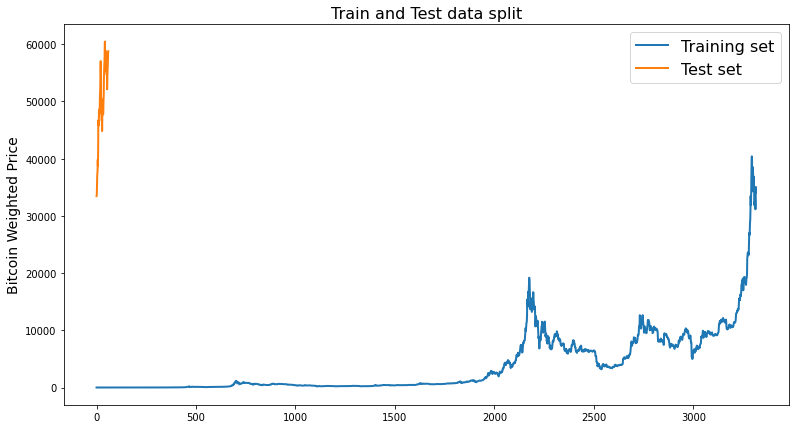

In [20]:
test_set_prediction_days = 60

# Set Train data to be upto Total data length - test_set_prediction_days
train_set= btc_weighted_price_groupby_date[:len(btc_weighted_price_groupby_date)-test_set_prediction_days].values.reshape(-1,1)
#train_set= btc_closing_price_groupby_date[:len(btc_closing_price_groupby_date)-test_set_prediction_days].values.reshape(-1,1)

# Set Test data to be the last prediction_days 
test_set= btc_weighted_price_groupby_date[len(btc_weighted_price_groupby_date)-test_set_prediction_days:].values.reshape(-1,1)
#test_set= btc_closing_price_groupby_date[len(btc_closing_price_groupby_date)-test_set_prediction_days:].values.reshape(-1,1)


print("\nDisplay the train dataset")
print("\nShape of the train dataset :", train_set.shape)
display(train_set)

print("\nDisplay the test dataset")
print("\nShape of the test dataset :", test_set.shape)
display(test_set)

_, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(train_set, label='Training set', linewidth=2)
ax.plot(test_set, label='Test set', linewidth=2)
ax.set_ylabel('Time', fontsize=14)
ax.set_ylabel('Bitcoin Weighted Price', fontsize=14)
ax.set_title('Train and Test data split', fontsize=16)
ax.legend(loc='best', fontsize=16)

## Feature Scaling.

Feature scaling is the process of scaling the values of features in a dataset so that they proportionally contribute to the distance calculation (Myrianthous, 2020). 

Since we are using the Relu activation function in our LSTM and Simple RNN models the Min-Max scaling in used to scale the data.

In [36]:
scaler_train = MinMaxScaler(feature_range=(0, 1))
scaled_train_set = scaler_train.fit_transform(train_set)

scaler_test = MinMaxScaler(feature_range=(0, 1))
scaled_test_set = scaler_test.fit_transform(test_set)

print("\nDisplay the scaled train and test dataset")
print("\nShape of the scaled train dataset :", scaled_train_set.shape)
display(scaled_train_set)

print("\nDisplay the scaled test dataset")
print("\nShape of the scaled test dataset :", scaled_test_set.shape)
display(scaled_test_set)


Display the scaled train and test dataset

Shape of the scaled train dataset : (3039, 1)


array([[7.29524503e-06],
       [2.47630077e-05],
       [3.48419862e-05],
       ...,
       [3.96180072e-01],
       [4.02028172e-01],
       [4.02805319e-01]])


Display the scaled test dataset

Shape of the scaled test dataset : (337, 1)


array([[0.        ],
       [0.01242199],
       [0.01032214],
       [0.01203344],
       [0.01406184],
       [0.01009159],
       [0.01312373],
       [0.01759352],
       [0.02387417],
       [0.03215353],
       [0.02837547],
       [0.00846125],
       [0.00883047],
       [0.01012344],
       [0.01532539],
       [0.02550191],
       [0.02447829],
       [0.02217658],
       [0.02645383],
       [0.02827223],
       [0.02728648],
       [0.02729477],
       [0.01979692],
       [0.01683442],
       [0.01838842],
       [0.01672783],
       [0.01098412],
       [0.01175432],
       [0.0150245 ],
       [0.02060485],
       [0.02314632],
       [0.02416332],
       [0.02491749],
       [0.02565634],
       [0.03131309],
       [0.02501807],
       [0.02786274],
       [0.02865932],
       [0.02664814],
       [0.02628783],
       [0.02834252],
       [0.02809977],
       [0.02954982],
       [0.02670423],
       [0.02232675],
       [0.0226251 ],
       [0.02217034],
       [0.019

## Generate the data structures for LSTM.

In Keras, the number of time steps is equal to the number of LSTM cells. This is what the word “time steps” means in the 3D tensor of the shape (batch_size, timesteps, input_dim). This means the input layer expects a 3D array of data when fitting the model and when making predictions, even if specific dimensions of the array contain a single value.

The time_steps defines how many previous time-steps are used in order to predict
the subsequent time-step(s). 

I've experimented with `time_steps = 10` and `time_steps = 5`. 10 time-steps produced the best results.


In [67]:
# Function to generate the datasets for trainning
def generate_dataset_for_lstm(input_dataset, time_steps=5):
    # The time_steps defines the window-size of how many
    # previous times-teps are used in order to predict
    # the subsequent time-step. 

    X = []
    Y = []
    
    for i in range(len(input_dataset) - time_steps):
        window_size_x = input_dataset[i:(i + time_steps), 0]
        X.append(window_size_x)
        actual = input_dataset[i + time_steps, 0] # this is the actual y-value
        Y.append(actual) 
    return np.array(X), np.array(Y)


# Set Timesteps
time_steps = 10
#time_steps = 5

X_train, Y_train = generate_dataset_for_lstm(scaled_train_set, time_steps)
X_test, Y_test = generate_dataset_for_lstm(scaled_test_set, time_steps)

print("Shape of X_train, Y_train, X_test, and Y_test-------------------")
print("trainX:", X_train.shape)
print("trainY:", Y_train.shape)
print("testX :", X_test.shape)
print("testY :", Y_test.shape)


print("\nData in  X_train, Y_train, X_test, and Y_test------------------")
print("trainX:", X_train)
print("trainY:", Y_train)
print("testX :", X_test)
print("testY :", Y_test)

Shape of X_train, Y_train, X_test, and Y_test-------------------
trainX: (3029, 10)
trainY: (3029,)
testX : (327, 10)
testY : (327,)

Data in  X_train, Y_train, X_test, and Y_test------------------
trainX: [[7.29524503e-06 2.47630077e-05 3.48419862e-05 ... 1.28680752e-04
  1.36500649e-04 1.17355960e-04]
 [2.47630077e-05 3.48419862e-05 4.80054798e-05 ... 1.36500649e-04
  1.17355960e-04 1.18410621e-04]
 [3.48419862e-05 4.80054798e-05 4.56938824e-05 ... 1.17355960e-04
  1.18410621e-04 1.45398902e-04]
 ...
 [3.60254047e-01 3.68451143e-01 3.72727364e-01 ... 3.80541514e-01
  3.91896445e-01 3.93101193e-01]
 [3.68451143e-01 3.72727364e-01 3.73407221e-01 ... 3.91896445e-01
  3.93101193e-01 3.96180072e-01]
 [3.72727364e-01 3.73407221e-01 3.67336779e-01 ... 3.93101193e-01
  3.96180072e-01 4.02028172e-01]]
trainY: [1.18410621e-04 1.45398902e-04 1.42365572e-04 ... 3.96180072e-01
 4.02028172e-01 4.02805319e-01]
testX : [[0.         0.01242199 0.01032214 ... 0.01759352 0.02387417 0.03215353]
 [0.0124

### Reshape X_train and X_test to 3D.

As discussed above, here we `reshape` the test and taining sets to 3D arrays of [samples, time-steps, features] for the LSTM.

In [68]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1 ))

print("Shape of trainX and testX after reshaping to 3D-------------------")
print("Shape of trainX: ", X_train.shape)
print("Shape of testX: ", X_test.shape)

print("Data in trainX and testX------------------------------------------")
print("trainX: ", X_train)
print("testX: ", X_test)

Shape of trainX and testX after reshaping to 3D-------------------
Shape of trainX:  (3029, 10, 1)
Shape of testX:  (327, 10, 1)
Data in trainX and testX------------------------------------------
trainX:  [[[7.29524503e-06]
  [2.47630077e-05]
  [3.48419862e-05]
  ...
  [1.28680752e-04]
  [1.36500649e-04]
  [1.17355960e-04]]

 [[2.47630077e-05]
  [3.48419862e-05]
  [4.80054798e-05]
  ...
  [1.36500649e-04]
  [1.17355960e-04]
  [1.18410621e-04]]

 [[3.48419862e-05]
  [4.80054798e-05]
  [4.56938824e-05]
  ...
  [1.17355960e-04]
  [1.18410621e-04]
  [1.45398902e-04]]

 ...

 [[3.60254047e-01]
  [3.68451143e-01]
  [3.72727364e-01]
  ...
  [3.80541514e-01]
  [3.91896445e-01]
  [3.93101193e-01]]

 [[3.68451143e-01]
  [3.72727364e-01]
  [3.73407221e-01]
  ...
  [3.91896445e-01]
  [3.93101193e-01]
  [3.96180072e-01]]

 [[3.72727364e-01]
  [3.73407221e-01]
  [3.67336779e-01]
  ...
  [3.93101193e-01]
  [3.96180072e-01]
  [4.02028172e-01]]]
testX:  [[[0.        ]
  [0.01242199]
  [0.01032214]
  ..

# LSTM Model.

Now we can create the LSTM model, train it and evaluate the performance of the model.


## Create the LSTM Model

Started with three hidden layers. The first layer with 256 neurons and the second and third layers with 64 cells each. dropout values were 0.2 for each layer but the model didn't generalize well. the Root mean squared error score were as follows

```
Train Score: 1559.054
Test Score: 7121.719
```

The model performance improved after reducing to two layers, the first layer with 128 neurons and the second layer of 64 neurons.


I'll sumarize the best perormance in the next step.




In [69]:
# A Function to create the LSTM Model
def create_lstm_model(X_train, activation = 'relu'):
  model = Sequential()

  # The first LSTM layer with 128 neurons and some dropout regularisation.
  # The return_sequences is set to true as a second LSTM layer is added.
  # This layer has a compatible n-dimensional sequence input.
  # This hyper parameter should be set to False (which is the default value) for the last layer
  # and true for the other previous layers.

  model.add(LSTM(units = 128, activation = activation, return_sequences=True, input_shape = (X_train.shape[1], X_train.shape[2])))
  model.add(Dropout(0.3))

  # A second LSTM layer with 64 neurons and some dropout regularisation
  model.add(LSTM(units = 64, activation = activation, input_shape = (X_train.shape[1], X_train.shape[2])))
  #model.add(LSTM(units = 64, activation = activation, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
  model.add(Dropout(0.3))

  # A third LSTM layer with 64 neurons and some dropout regularisation
  #model.add(LSTM(units = 64, input_shape = (X_train.shape[1], X_train.shape[2])))
  #model.add(Dropout(0.2))

  # The output layer
  model.add(Dense(units = 1))

  model.summary()

  return model

## Train the model.

While training and evaluating, I constantly encountered the overfitting problem. Therefore, I applied the following regularization techniques to achieve a better RMSE score.


*  Increased the dropouts to 0.5 and then 0.3. 0.3 produced better results.
*  Implemented `Early Stopping` and model checkpoint as the early stopping didn’t work well without the checkpoints. https://keras.io/api/models/model_training_apis/

*  Changed the batch size from `50` to `32`. `32` worked well.
*  Tested with `adam` and `nadam` optimizes, and `nadam` produced better results.

*   Tested the `lstm_model.fit` function with `validation_data=(X_test, Y_test)` and ` validation_split=0.2` parameters. ` validation_split ` resulted in overfitting which makes sense as it splits the training set for training and validation and use the validation set internally to evaluate loss in each epoch  https://keras.io/api/models/model_training_apis/. Using ` validation_data=(X_test, Y_test)` with the test samples produced better RMSE scores.



Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 10, 128)           66560     
                                                                 
 dropout_18 (Dropout)        (None, 10, 128)           0         
                                                                 
 lstm_19 (LSTM)              (None, 64)                49408     
                                                                 
 dropout_19 (Dropout)        (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                                                                 
Total params: 116,033
Trainable params: 116,033
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
93/95 [============================>

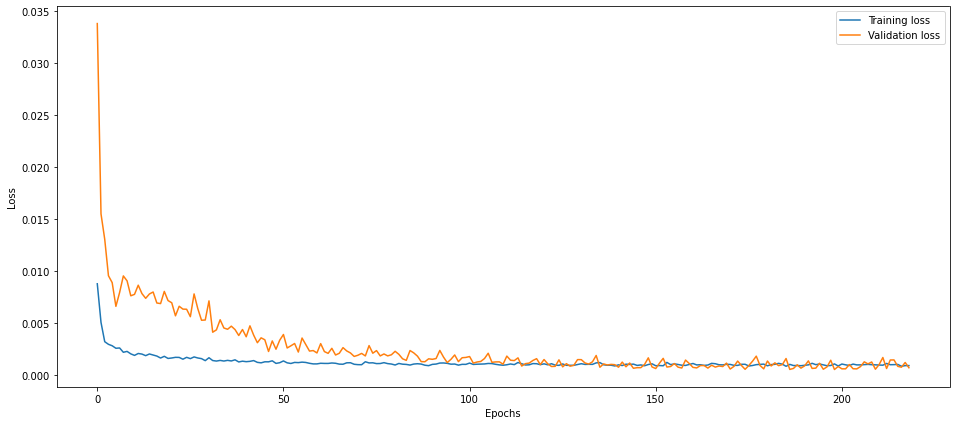

In [70]:
ACTIVATION_FUNCTION = 'relu'
NUM_OF_EPOCHS = 500
# BATCH_SIZE = 50 
BATCH_SIZE = 32
#OPTIMIZER = 'adam'
OPTIMIZER = 'nadam'
EVALUATION_METRIC = 'mean_squared_error'

lstm_model = create_lstm_model(X_train, ACTIVATION_FUNCTION)

lstm_model.compile(optimizer = OPTIMIZER, loss = EVALUATION_METRIC)


checkpoint_file_path = checkpoint_file_path = f'checkpoint_{int(time.time())}.hdf5'
checkpoint = ModelCheckpoint(filepath='checkpoint.hdf5', 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')


earlystop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# List of callbacks to apply during training, we are adding the checkpoint to save the model and earlystopping with patience=20. 
callbacks = [checkpoint, earlystop] 

#Setting the  validation_data paramter with the X_test and Y_test sets. validation_data will override validation_split. https://keras.io/api/models/model_training_apis/
#history = lstm_model.fit(X_train, Y_train, batch_size = BATCH_SIZE, epochs = NUM_OF_EPOCHS, verbose=1, shuffle=False, validation_data=(X_test, Y_test))
history = lstm_model.fit(X_train, Y_train, batch_size = BATCH_SIZE, epochs = NUM_OF_EPOCHS, verbose=1, shuffle=False, validation_data=(X_test, Y_test), callbacks=callbacks)

#Setting the validation_split paramter. 
#Since we are not setting the validation_data paramter the traning process will allocate fraction of the training data to be used as validation data.
# https://keras.io/api/models/model_training_apis/
#history = lstm_model.fit(X_train, Y_train, batch_size = BATCH_SIZE, epochs = NUM_OF_EPOCHS, validation_split=0.2, verbose=1, shuffle=False)
#history = lstm_model.fit(X_train, Y_train, batch_size = BATCH_SIZE, epochs = NUM_OF_EPOCHS, validation_split=0.2, verbose=1, shuffle=False, callbacks=callbacks)


plt.figure(figsize=(16,7))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title("LSTM Model Loss.")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Model Evaluation

### Model Predictions.

Predictions using the test set.

11/11 [==============================] - 0s 10ms/step


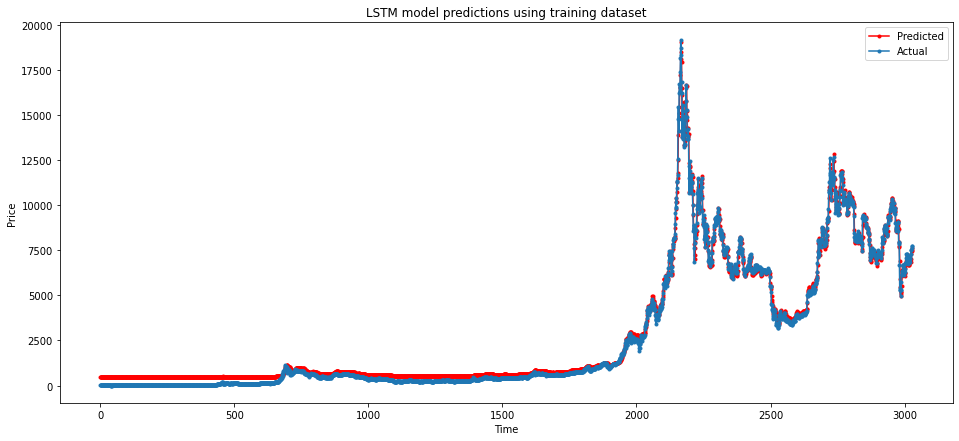

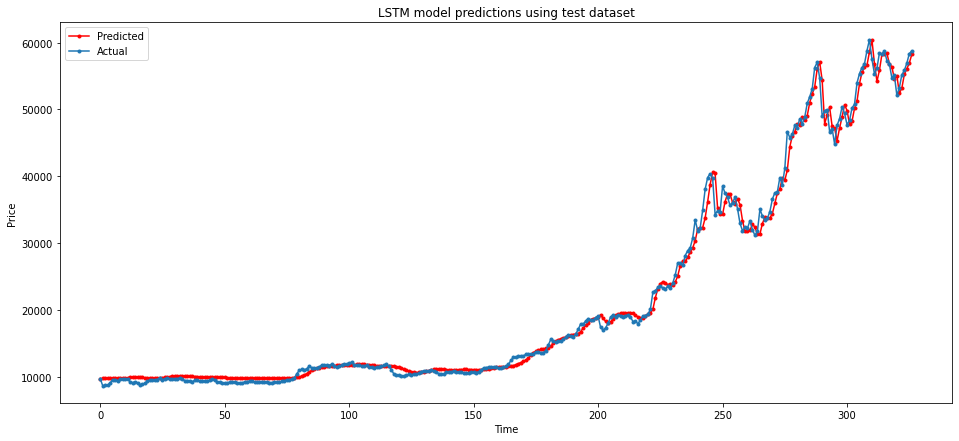

In [74]:
predicted_btc_price_from_train_set = lstm_model.predict(X_train)
predicted_btc_price_from_train_set = scaler_train.inverse_transform(predicted_btc_price_from_train_set.reshape(-1, 1))
actual_from_train_set = scaler_train.inverse_transform(Y_train.reshape(-1, 1))

predicted_btc_price_from_test_set = lstm_model.predict(X_test)
predicted_btc_price_from_test_set = scaler_test.inverse_transform(predicted_btc_price_from_test_set.reshape(-1, 1))
actual_from_test_set = scaler_test.inverse_transform(Y_test.reshape(-1, 1))

plt.figure(figsize=(16,7))
plt.plot(predicted_btc_price_from_train_set, 'r', marker='.', label='Predicted')
plt.plot(actual_from_train_set, marker='.', label='Actual')
plt.title("LSTM model predictions using training dataset")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()

plt.figure(figsize=(16,7))
plt.plot(predicted_btc_price_from_test_set, 'r', marker='.', label='Predicted')
plt.plot(actual_from_test_set, marker='.', label='Actual')
plt.title("LSTM model predictions using test dataset")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()

### Root mean squared errors (RMSE)

Here are some of the RMSE numbers observed so far.

Best performance

*   Dropout rate = 0.3.
*   Two LSTM layers as the code reflected above.
*   Time-steps = 10.
*   Early stopping - Yes.
*   Used validation_data=(X_test, Y_test) over validation_split.
RMSE score:
```
Train Score: 328.878
Test Score: 1167.443
```

*   Dropout rate = 0.3.
*   Two LSTM layers as the code reflected above.
*   Time-steps = 10.
*   Early stopping - No. 500 epochs instead.
*   Used validation_data=(X_test, Y_test) over validation_split.
RMSE score:

```
Train Score: 294.300
Test Score: 1330.862
```

Some worst performance examples.

*   Dropout rate = 0.2.
*   Two LSTM layers as the code reflected above.
*   Time-steps = 5.
*   Early stopping - Yes.
*   Used validation_split.
RMSE score:
```
Train Score: 445.663
Test Score: 2516.734
```

*   Dropout rate = 0.2.
*   Two LSTM layers as the code reflected above.
*   Time-steps = 5.
*   Early stopping - Yes.
*   Used validation_split.
*   Optimizer - `adam`
RMSE score:
```
Train Score: 1430.066
Test Score: 3950.170
```



In [72]:
rmse_lstm_train = math.sqrt(mean_squared_error(actual_from_train_set, predicted_btc_price_from_train_set))
rmse_lstm_test = math.sqrt(mean_squared_error(actual_from_test_set, predicted_btc_price_from_test_set))
print('Train Score: %.3f' % rmse_lstm_train)
print('Test Score: %.3f' % rmse_lstm_test)

Train Score: 328.878
Test Score: 1167.443


# Simple RNN Model.

As discussed in the project proposal we are creating a Simple RNN Model so that I can compare with the LSTM model above. We can use the same sclased traning and test datasets for the RNN Model.



## Create the Simple RNN Model

In [78]:
# A Function to create the Simple RNN Model
def create_rnn_model(X_train, activation = 'relu'):
  model = Sequential()

  # The first LSTM layer with 64 neurons and some dropout regularisation.
  model.add(SimpleRNN(units = 64, activation = activation, return_sequences=True, input_shape = (X_train.shape[1], 1)))
  model.add(Dropout(0.3))

  # A second layer with 64 neurons and some dropout regularisation  
  model.add(SimpleRNN(units = 64, activation = activation, return_sequences = True))
  model.add(Dropout(0.3))

  # A third  layer with 64 neurons and some dropout regularisation
  model.add(SimpleRNN(units = 64))
  model.add(Dropout(0.3))

  # The output layer
  model.add(Dense(units = 1))

  model.summary()

  return model

## Train the RNN model

Used the same input data sets used for the LSTM model.

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 10, 64)            4224      
                                                                 
 dropout_20 (Dropout)        (None, 10, 64)            0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 10, 64)            8256      
                                                                 
 dropout_21 (Dropout)        (None, 10, 64)            0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 64)                8256      
                                                                 
 dropout_22 (Dropout)        (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 1)               

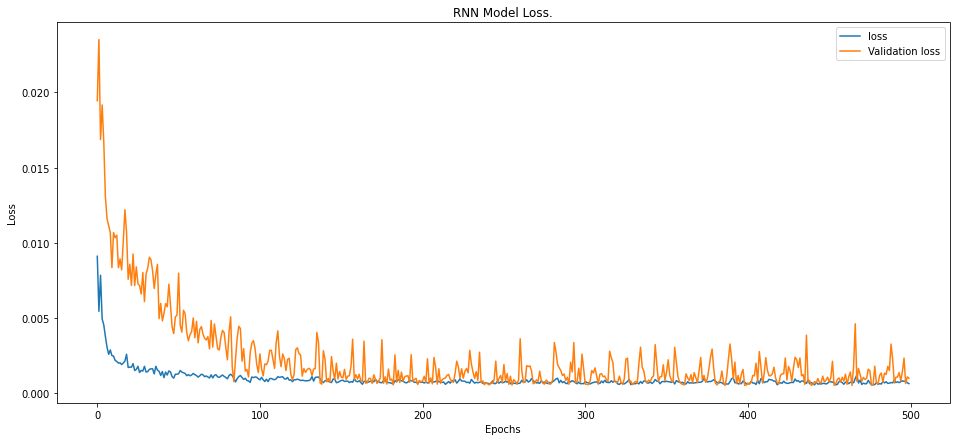

In [79]:
ACTIVATION_FUNCTION = 'relu'
NUM_OF_EPOCHS = 500
BATCH_SIZE = 32
#BATCH_SIZE = 50 
OPTIMIZER = 'nadam'
EVALUATION_METRIC = 'mean_squared_error'

rnn_model = create_rnn_model(X_train, ACTIVATION_FUNCTION)

rnn_model.compile(optimizer = OPTIMIZER, loss = EVALUATION_METRIC)

earlystop = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

callbacks = [earlystop]

#history_rnn = rnn_model.fit(X_train, Y_train, batch_size = BATCH_SIZE, epochs = NUM_OF_EPOCHS, validation_split=0.2, verbose=1, shuffle=False)
history_rnn = rnn_model.fit(X_train, Y_train, batch_size = BATCH_SIZE, epochs = NUM_OF_EPOCHS, verbose=1, shuffle=False, validation_data=(X_test, Y_test))
#history_rnn = rnn_model.fit(X_train, Y_train, batch_size = BATCH_SIZE, epochs = NUM_OF_EPOCHS, validation_split=0.2, verbose=1, shuffle=False, callbacks=callbacks)


plt.figure(figsize=(16,7))
plt.plot(history_rnn.history['loss'], label='loss')
plt.plot(history_rnn.history['val_loss'], label='Validation loss')
plt.title("RNN Model Loss.")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

## RNN Model Evaluation

Surprisingly the performance is not bad.

### Model Predictions.

11/11 [==============================] - 0s 4ms/step


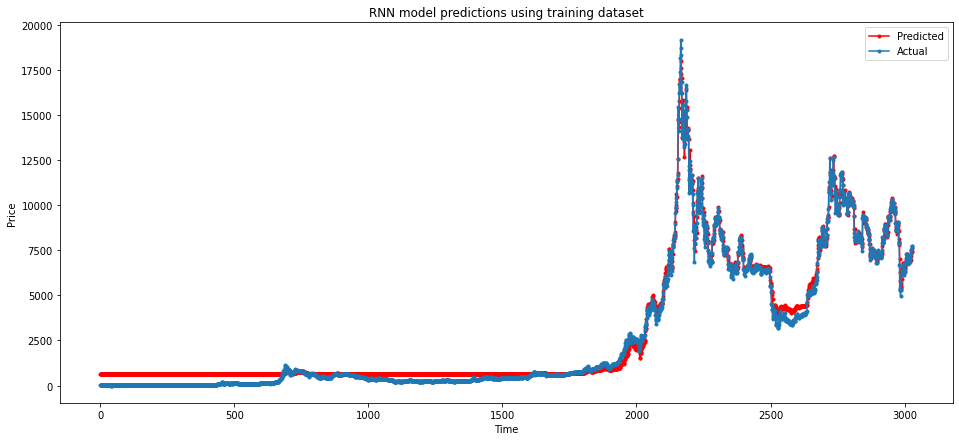

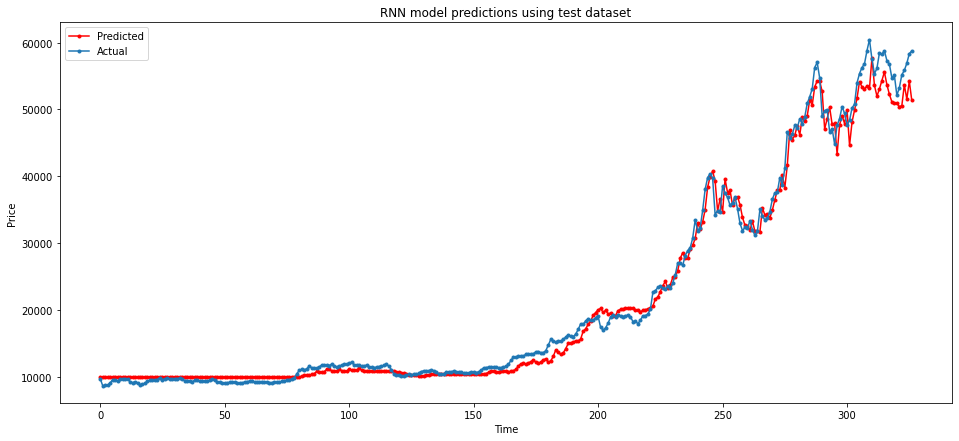

In [80]:
predicted_btc_price_from_train_set = rnn_model.predict(X_train)
predicted_btc_price_from_train_set = scaler_train.inverse_transform(predicted_btc_price_from_train_set.reshape(-1, 1))
actual_from_train_set = scaler_train.inverse_transform(Y_train.reshape(-1, 1))

predicted_btc_price_from_test_set = rnn_model.predict(X_test)
predicted_btc_price_from_test_set = scaler_test.inverse_transform(predicted_btc_price_from_test_set.reshape(-1, 1))
actual_from_test_set = scaler_test.inverse_transform(Y_test.reshape(-1, 1))

plt.figure(figsize=(16,7))
plt.plot(predicted_btc_price_from_train_set, 'r', marker='.', label='Predicted')
plt.plot(actual_from_train_set, marker='.', label='Actual')
plt.title("RNN model predictions using training dataset")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()

plt.figure(figsize=(16,7))
plt.plot(predicted_btc_price_from_test_set, 'r', marker='.', label='Predicted')
plt.plot(actual_from_test_set, marker='.', label='Actual')
plt.title("RNN model predictions using test dataset")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()

### Root mean squared errors (RMSE)

In [81]:
rmse_rnn_train = math.sqrt(mean_squared_error(actual_from_train_set, predicted_btc_price_from_train_set))
rmse_rnn_test = math.sqrt(mean_squared_error(actual_from_test_set, predicted_btc_price_from_test_set))
print('Train Score: %.3f' % rmse_rnn_train)
print('Test Score: %.3f' % rmse_rnn_test)

Train Score: 402.695
Test Score: 1658.866


# References

Goodfellow, I., Bengio, Y. Courville, A. (2016). Deep Learning. The MIT Press. 

Myrianthous, G. (2020). Feature Scaling and Normalisation in a Nutshell. Retrieved 28 July 2022, from https://towardsdatascience.com/feature-scaling-and-normalisation-in-a-nutshell-5319af86f89b

Nasirtafreshi, I. (2022). Forecasting cryptocurrency prices using Recurrent Neural Network and Long Short-term Memory. Data & Knowledge Engineering, 139, 102009. https://doi.org/https://doi.org/10.1016/j.datak.2022.102009

Team, K. (2022a). Keras documentation: Keras API reference. Retrieved 30 July 2022, from https://keras.io/api/

Team, K. (2022b). Keras documentation: Model training APIs. Retrieved 31 July 2022, from https://keras.io/api/models/model_training_apis/

Zielak. (2021). Bitcoin Historical Data. Kaggle.Com. https://www.kaggle.com/datasets/mczielinski/bitcoin-historical-data?select=bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv